## Import des packages 

In [13]:
import os
import cv2
import pickle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from data_morph.data.loader import DataLoader
from data_morph.shapes.factory import ShapeFactory
from data_morph.morpher import DataMorpher
from IPython.display import Image

import torch
from ddpm import get_dataset, viz_sample, viz_samples, NoiseScheduler, reconstruct, denoise

from skimage.transform import resize

## Identifier les contours des objets

Le but est d'arriver à détecter les contours des objets sur une image et de pouvoir en extraire les coordonnées des contours. Pour cela on utilise la libraire cv2

### Pour une image internet simple

On utilise une image d'avion simple trouvée sur internet

In [2]:
image = cv2.imread('img_avion.png')

# Convertir l'image en niveaux de gris

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer un flou gaussien 

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Appliquer l'algorithme de détection de contours 

edges = cv2.Canny(blurred, 30, 150)

# Trouver les contours dans l'image

contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dessin des contours sur une copie de l'image

contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

cv2.imshow('Original', image)
cv2.imshow('Contours', contour_image)

# Configuration de la touche ESC pour stopper le code 

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  
        break

cv2.destroyAllWindows()

### Pour une image issue de CIFAR-10

Pour des images d'une complexité supérieur l'identification des contours fonctionne même si ils sont moins précis

In [1]:
# Charger une image d'avion de CIFAR-10

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

data = batch_1[b'data']
labels = batch_1[b'labels']

index_avion = labels.index(0)

image_avion = data[index_avion].reshape(3, 32, 32).transpose(1, 2, 0)

image_avion_bgr = cv2.cvtColor(image_avion, cv2.COLOR_RGB2BGR)


# Convertir l'image en niveaux de gris

gray = cv2.cvtColor(image_avion_bgr, cv2.COLOR_BGR2GRAY)

# Appliquer l'algorithme de détection de contours

edges = cv2.Canny(gray, 30, 150)

# Trouver les contours dans l'image

contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dessin des contours sur une copie de l'image

contour_image = image_avion_bgr.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

cv2.imshow('Original', image_avion_bgr)
cv2.imshow('Contours', contour_image)

# Configuration de la touche ESC pour stopper le code 

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # Touche ESC
        break

cv2.destroyAllWindows() 

## Récupérer les coordonnées de l'objet 

### Pour une image internet simple

In [2]:
image = cv2.imread('img_avion.png')

# Convertir l'image en niveaux de gris

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer un flou gaussien 

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Appliquer l'algorithme de détection de contours

edges = cv2.Canny(blurred, 30, 150)

# Trouver les contours dans l'image

contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_data = []

for contour in contours:
    for point in contour:
        x, y = point[0] 
        contour_data.append({'x': x, 'y': y})

In [3]:
# Vérifier que les coordonnées des contours se sont bien enregistrées 

contour_df = pd.DataFrame(contour_data)
print(contour_df.head())

     x    y
0  713  127
1  712  128
2  707  128
3  706  129
4  702  129


### Pour une image de CIFAR-10 

In [54]:
# Charger une image d'avion de CIFAR-10

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

data = batch_1[b'data']
labels = batch_1[b'labels']

index_avion = labels.index(0)

image_avion = data[index_avion].reshape(3, 32, 32).transpose(1, 2, 0)

image_avion_bgr = cv2.cvtColor(image_avion, cv2.COLOR_RGB2BGR)


# Convertir l'image en niveaux de gris

gray = cv2.cvtColor(image_avion_bgr, cv2.COLOR_BGR2GRAY)

# Appliquer l'algorithme de détection de contours 

edges = cv2.Canny(gray, 30, 150)

# Trouver les contours dans l'image

contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contour_data_cifar = []

for contour in contours:
    for point in contour:
        x, y = point[0]  
        contour_data_cifar.append({'x': x, 'y': y})

In [56]:
# Vérifier que les coordonnées des contours se sont bien enregistrées 

contour_df_cifar = pd.DataFrame(contour_data_cifar)
print(contour_df_cifar.head())

    x   y
0  22  28
1  22  29
2  23  30
3  23  31
4  23  30


## Utilisation de Datamorph 

### Exploration de la librairie 

Lien vers le notebook : https://stefaniemolin.com/data-morph/stable/index.html

In [11]:
# Exemple de morphisme à partir des dataset de la librairie

!data-morph --start-shape panda --target-shape star --freeze 50 --ramp-in --ramp-out --output-dir morphed_data2

Processing starter shape 'panda'
star pattern: 100%|####################| 100000/100000 [03:39<00:00, 455.08it/s]


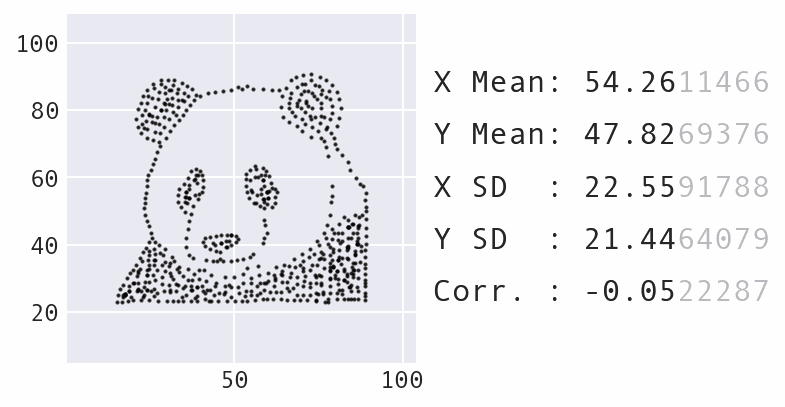

In [12]:
# Afficher la transformation

from IPython.display import Image

gif_path = 'morphed_data/panda_to_star.gif'

Image(filename=gif_path)

### Application aux contours

In [28]:
# Prétraiter les coordonnées de l'avion pour les rendre compatibles avec DataMorph

contour_points = list(zip(contour_df['x'], contour_df['y']))

# Charger le panda comme forme de départ

panda_dataset = DataLoader.load_dataset('panda')

# Créer la forme cible à partir de contour_df

class CustomShape:
    def __init__(self, contour_points):
        self.contour_points = contour_points
    
    def get_points(self):
        return self.contour_points
    
    def distance(self, x, y):
        # Calculer la distance minimale entre le point (x, y) et les points du contour
        distances = [np.sqrt((x - px) ** 2 + (y - py) ** 2) for px, py in self.contour_points]
        return min(distances)

custom_shape = CustomShape(contour_points)

# Mise en place du morphisme avec DataMorph

morpher = DataMorpher(
    decimals=2,
    in_notebook=False,  # Indique si vous exécutez dans un notebook Jupyter
    output_dir='data_morph/output',  # Répertoire de sortie pour les images générées
)

result = morpher.morph(
    start_shape=panda_dataset,
    target_shape=custom_shape,
    freeze_for=50,
    ramp_in=True,
    ramp_out=True,
)

<__main__.CustomShape object at 0x13253f450> pattern: 100%|#| 100000/100000 [17:


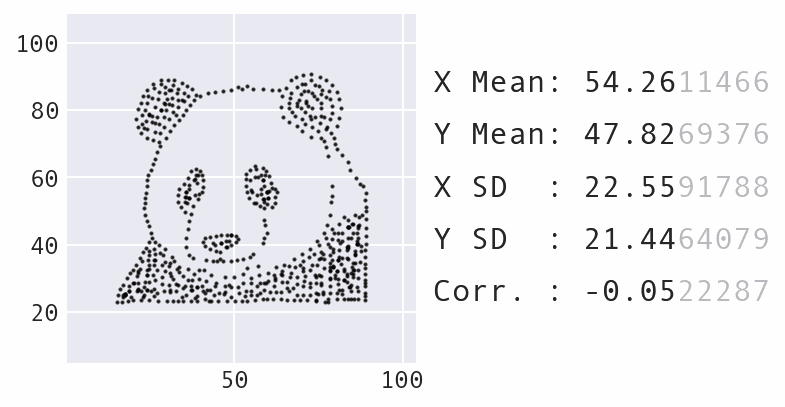

In [38]:
# Afficher la transformation

from IPython.display import Image

gif_path = 'data_morph/output/panda_to_<__main__.CustomShape object at 0x13253f450>.gif'

Image(filename=gif_path)

Le prétraitrement des données nécessaire pour la mise en place des morphismes n'étant pas spécifiée nous avons essayé de transformer nous même les données afin de pouvoir effectuer le morphisme avec nos propres contours. Malgré plusieurs essais cela ne semble pas fonctionner. La mise en place d'un modèle de segmentation semble plus appropriée. 

Les transformations effectuées pour notre shape d'avion sont les suivantes : 

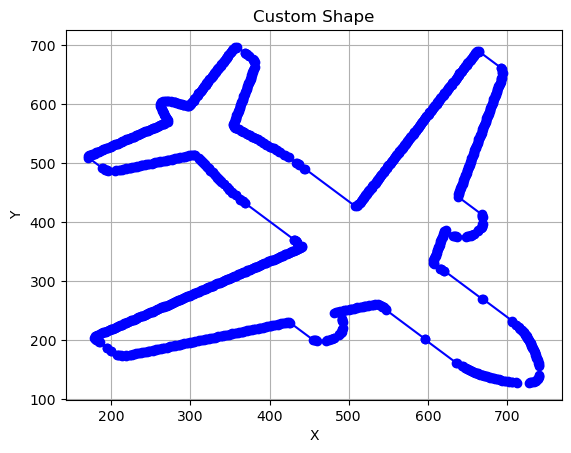

In [30]:
# Coordonnées de l'avion avant transformation 

x_coords = contour_df['x']
y_coords = contour_df['y']

plt.figure()
plt.plot(x_coords, y_coords, color='blue', marker='o', linestyle='-')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Custom Shape')
plt.grid(True)
plt.show()

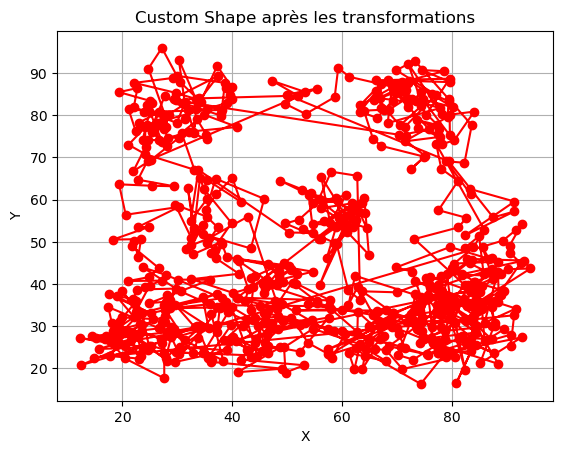

In [31]:
# Coordonnées de l'avion après transformation 

x_coords_result = result['x']
y_coords_result = result['y']

plt.figure()
plt.plot(x_coords_result, y_coords_result, color='red', marker='o', linestyle='-')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Custom Shape après les transformations')
plt.grid(True)
plt.show()

## Tiny diffusion

Mise en place d'un modèle de tiny diffusion sur notre shape d'avion 

In [33]:
!git clone https://github.com/Kei18/tiny-tiny-diffusion.git

fatal : le chemin de destination 'tiny-tiny-diffusion' existe déjà et n'est pas un répertoire vide.


In [36]:
# Définir le chemin du répertoire où se trouve le fichier pyproject.toml
chemin_répertoire = '/Users/clementlaure/Desktop/ENSAE/S2/Deep learning/Small_diffusion_model/tiny-tiny-diffusion'

# Changer le répertoire de travail
os.chdir(chemin_répertoire)

In [37]:
!poetry install

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: tiny-tiny-diffusion (0.1.0)Installing the current project: tiny-tiny-diffusion (0.1.0)


## Pour l'image internet

In [12]:
# Sauvegarde des coordonnées des contours de l'avion sous forme d'un fichier csv

nom_fichier_csv = "contour_data.csv"

contour_df.to_csv(nom_fichier_csv, index=False)

print("Le DataFrame a été enregistré sous forme de fichier CSV avec succès.")

Le DataFrame a été enregistré sous forme de fichier CSV avec succès.


In [15]:
# Entraînement du modèle

!poetry run python ddpm/train.py dataset.csv_file=contour_data.csv

100%|██████████████████████████| 1000/1000 [02:50<00:00,  5.87it/s, loss=1.2656]
saving model to /Users/clementlaure/Desktop/ENSAE/S2/Deep learning/Small_diffusion_model/tiny-tiny-diffusion/learning_results/2024-03-28_18-49-55


Le résultat du modèle de tiny diffusion est disponible sur jupyter lab en lançant le fichier visualisation_plane_tiny_diffusion

Il est également visible sous forme de GIF ci-dessous

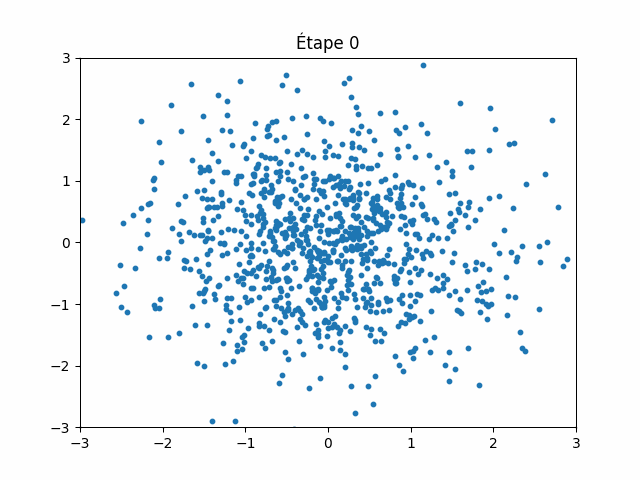

In [47]:
Image(filename='animation_plane.gif')

## Pour l'image de CIFAR-10

In [57]:
# Sauvegarde des coordonnées des contours de l'avion sous forme d'un fichier csv

nom_fichier_csv = "contour_data_cifar.csv"

contour_df_cifar.to_csv(nom_fichier_csv, index=False)

print("Le DataFrame a été enregistré sous forme de fichier CSV avec succès.")

Le DataFrame a été enregistré sous forme de fichier CSV avec succès.


In [58]:
# Entraînement du modèle

!poetry run python ddpm/train.py dataset.csv_file=contour_data_cifar.csv

100%|██████████████████████████| 1000/1000 [02:58<00:00,  5.60it/s, loss=1.2296]
saving model to /Users/clementlaure/Desktop/ENSAE/S2/Deep learning/Small_diffusion_model/tiny-tiny-diffusion/learning_results/2024-03-29_18-41-49


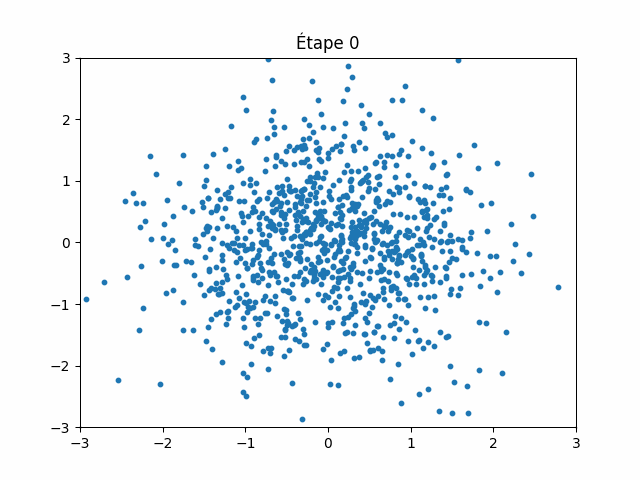

In [60]:
Image(filename='animation_cifar.gif')

On notera que le résultat final est moins probant de par la complexité de l'image

### Les GIF de résultat des modèles sont disponibles dans le dossier tiny-tiny-diffusion sous les noms animation_cifar et animation_plane